In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
library(methods)
Snakemake <- setClass(
    "Snakemake",
    slots = c(
        input = "list",
        output = "list",
        params = "list",
        wildcards = "list",
        threads = "numeric",
        log = "list",
        resources = "list",
        config = "list",
        rule = "character",
        bench_iteration = "numeric",
        scriptdir = "character",
        source = "function"
    )
)
snakemake <- Snakemake(
    input = list('data/ATACseq_250kb_bins.txt', 'data/all_samples_normalized_gaussian_smooth_trimmed_CONTROLS.csv', 'data/all_samples_normalized_gaussian_smooth_trimmed_CASES.csv', "input_atac" = 'data/ATACseq_250kb_bins.txt', "input_train_data_trim" = 'data/all_samples_normalized_gaussian_smooth_trimmed_CONTROLS.csv', "input_test_data_trim" = 'data/all_samples_normalized_gaussian_smooth_trimmed_CASES.csv'),
    output = list('data/all_samples_train_ATAC_predictions_on_all_samples/all_samples_ATAC_pred_lasso_std_TRUE_gaussian_trimmed.csv', 'Trained_models/On_all_individuals/Lasso_models/lasso_std_TRUE_gaussian_trimmed.rds', "output_pred" = 'data/all_samples_train_ATAC_predictions_on_all_samples/all_samples_ATAC_pred_lasso_std_TRUE_gaussian_trimmed.csv', "output_model" = 'Trained_models/On_all_individuals/Lasso_models/lasso_std_TRUE_gaussian_trimmed.rds'),
    params = list(),
    wildcards = list(),
    threads = 2,
    log = list('logs/processed_notebooks/processed_all_samples_Smooth_gaussian_10_Lasso_reg_TRUE_Discard.r.ipynb', "notebook" = 'logs/processed_notebooks/processed_all_samples_Smooth_gaussian_10_Lasso_reg_TRUE_Discard.r.ipynb'),
    resources = list('mem_mb', 'disk_mb', 'tmpdir', 'time', "mem_mb" = 150000, "disk_mb" = 56743, "tmpdir" = '/scratch/55839911', "time" = '12:00:00'),
    config = list(),
    rule = 'all_samples_model_lasso_trimming',
    bench_iteration = as.numeric(NA),
    scriptdir = '/faststorage/project/DELFI1/Workspaces/CarmenAndAnika/ATAC_pred_models/Train_all_samples_models/Lasso_regression',
    source = function(...){
        wd <- getwd()
        setwd(snakemake@scriptdir)
        source(...)
        setwd(wd)
    }
)
setwd('/faststorage/project/DELFI1/Workspaces/CarmenAndAnika');

######## snakemake preamble end #########


# Lasso regression on data normalized, smoothed with Gaussian (n = 10) and trimmed (80 to 400) 

In [2]:
library(tidyverse)

library(glmnet)

install.packages("tidyr")
library(tidyr)


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16

Updating HTML index of packages in '.Library'
Making 'packages.html' ...

### Read in data and ATAC values, add ATAC values to the dataframe

In [3]:
#all_samples_gaussian_trimmed_controls <- read.csv("../../../data/all_samples_normalized_gaussian_smooth_trimmed_CONTROLS.csv", nrows=50000)
all_samples_gaussian_trimmed_controls <- read.csv(snakemake@input[["input_train_data_trim"]])

In [4]:
#ATAC <- read.table("../../../data/ATACseq_250kb_bins.txt", header = FALSE)
ATAC <- read.table(snakemake@input[["input_atac"]], header = FALSE)
colnames(ATAC) <- c("bin", "ATAC_observed")

ATAC$ATAC_observed <- as.character(ATAC$ATAC_observed)
ATAC$ATAC_observed <- as.numeric(ATAC$ATAC_observed)
ATAC$bin <- as.character(ATAC$bin)

all_samples_gaussian_trimmed_controls <- inner_join(all_samples_gaussian_trimmed_controls, ATAC, by="bin")

head(all_samples_gaussian_trimmed_controls)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

sample,bin,X80,X81,X82,X83,X84,X85,X86,X87,...,X392,X393,X394,X395,X396,X397,X398,X399,X400,ATAC_observed
PGDX16568P,chr10_400,2.656112e-05,2.994814e-05,2.961085e-05,2.929903e-05,3.469718e-05,3.917019e-05,4.629696e-05,5.955899e-05,...,1.753154e-04,1.569416e-04,0.0001385816,1.166854e-04,9.841735e-05,8.478873e-05,7.355554e-05,6.464917e-05,7.007278e-05,0.5866651
PGDX16568P,chr10_40,2.639605e-05,3.960356e-05,5.284513e-05,6.279401e-05,6.650374e-05,6.279401e-05,5.284513e-05,3.960356e-05,...,1.143096e-04,1.096515e-04,0.0001061073,1.087833e-04,1.047829e-04,9.925148e-05,8.919007e-05,7.883794e-05,7.639961e-05,0.1996134
PGDX16568P,chr10_4,4.192713e-05,6.023358e-05,7.256827e-05,7.906282e-05,7.854465e-05,7.167697e-05,7.860718e-05,8.606324e-05,...,1.238579e-04,1.192868e-04,0.0001246347,1.214730e-04,1.148990e-04,1.029420e-04,8.920670e-05,7.138334e-05,5.295770e-05,0.5968816
PGDX16568P,chr10_401,0.000000e+00,0.000000e+00,0.000000e+00,5.920236e-06,1.073402e-05,1.705132e-05,3.557204e-05,5.040596e-05,...,2.242108e-04,1.921067e-04,0.0001600517,1.301008e-04,1.037432e-04,8.040869e-05,7.337752e-05,8.314214e-05,8.566120e-05,0.2905764
PGDX16568P,chr10_402,2.723749e-05,3.321301e-05,3.548313e-05,3.321301e-05,2.723749e-05,2.636520e-05,3.143441e-05,4.547983e-05,...,3.316005e-05,2.463956e-05,0.0000263652,4.082719e-05,7.144226e-05,9.926339e-05,1.268287e-04,1.481385e-04,1.569626e-04,0.2319729
PGDX16568P,chr10_403,3.026954e-05,3.233848e-05,3.026954e-05,2.482360e-05,1.783596e-05,1.122795e-05,1.857799e-05,2.245591e-05,...,2.341484e-04,2.196942e-04,0.0002026050,1.707937e-04,1.339162e-04,9.654238e-05,6.627284e-05,4.648453e-05,3.525657e-05,0.2262170


In [5]:
ATAC_val <- all_samples_gaussian_trimmed_controls %>% select(ATAC_observed)
controls_predictions <- all_samples_gaussian_trimmed_controls %>% select(sample, bin)
all_samples_gaussian_trimmed_controls = all_samples_gaussian_trimmed_controls %>% select(-c(ATAC_observed, sample, bin))

head(all_samples_gaussian_trimmed_controls)

X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
2.656112e-05,2.994814e-05,2.961085e-05,2.929903e-05,3.469718e-05,3.917019e-05,4.629696e-05,5.955899e-05,6.912218e-05,9.150794e-05,...,1.797668e-04,1.753154e-04,1.569416e-04,0.0001385816,1.166854e-04,9.841735e-05,8.478873e-05,7.355554e-05,6.464917e-05,7.007278e-05
2.639605e-05,3.960356e-05,5.284513e-05,6.279401e-05,6.650374e-05,6.279401e-05,5.284513e-05,3.960356e-05,2.639605e-05,1.233419e-05,...,1.239199e-04,1.143096e-04,1.096515e-04,0.0001061073,1.087833e-04,1.047829e-04,9.925148e-05,8.919007e-05,7.883794e-05,7.639961e-05
4.192713e-05,6.023358e-05,7.256827e-05,7.906282e-05,7.854465e-05,7.167697e-05,7.860718e-05,8.606324e-05,1.001944e-04,1.253732e-04,...,1.251224e-04,1.238579e-04,1.192868e-04,0.0001246347,1.214730e-04,1.148990e-04,1.029420e-04,8.920670e-05,7.138334e-05,5.295770e-05
0.000000e+00,0.000000e+00,0.000000e+00,5.920236e-06,1.073402e-05,1.705132e-05,3.557204e-05,5.040596e-05,7.685896e-05,9.786910e-05,...,2.383188e-04,2.242108e-04,1.921067e-04,0.0001600517,1.301008e-04,1.037432e-04,8.040869e-05,7.337752e-05,8.314214e-05,8.566120e-05
2.723749e-05,3.321301e-05,3.548313e-05,3.321301e-05,2.723749e-05,2.636520e-05,3.143441e-05,4.547983e-05,6.592248e-05,9.234063e-05,...,3.955727e-05,3.316005e-05,2.463956e-05,0.0000263652,4.082719e-05,7.144226e-05,9.926339e-05,1.268287e-04,1.481385e-04,1.569626e-04
3.026954e-05,3.233848e-05,3.026954e-05,2.482360e-05,1.783596e-05,1.122795e-05,1.857799e-05,2.245591e-05,4.186458e-05,6.706782e-05,...,2.366995e-04,2.341484e-04,2.196942e-04,0.0002026050,1.707937e-04,1.339162e-04,9.654238e-05,6.627284e-05,4.648453e-05,3.525657e-05


## Finding the best lambda

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”

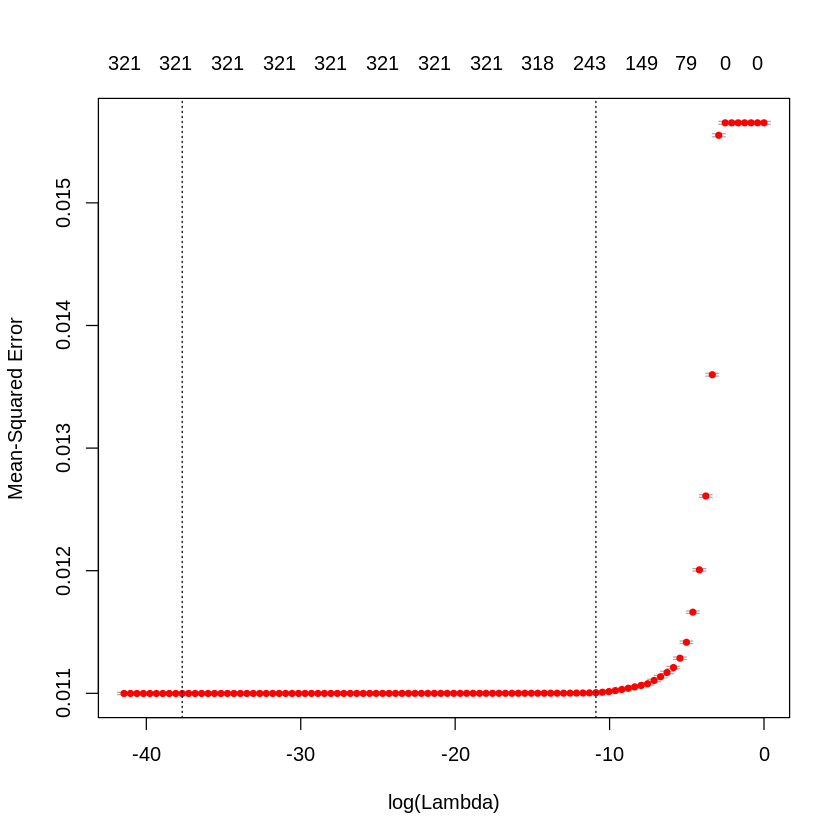

In [6]:
set.seed(0)
#X==predictor
#y==response

y <- ATAC_val %>% as.matrix()
X <- all_samples_gaussian_trimmed_controls %>% as.matrix()

lambdas_to_try <- 10^seq(-18, 0, length.out = 100)
#standardize = FALSE -- range -12, -3
#standardize = TRUE -- range -10, 0


lasso_smooth_cv <- cv.glmnet(X, y, alpha = 1, lambda = lambdas_to_try,
                      standardize = TRUE, nfolds = 10)

#Plotting the MSE and log(lambda)

plot(lasso_smooth_cv)

In [7]:
(lambda_smooth_cv <- lasso_smooth_cv$lambda.min)

[1] 4.328761e-17

In [8]:
CV_lasso_smooth<-function(data, nfolds){
    set.seed(0)
    cvfolds <- cut(1:nrow(data), breaks = nfolds, labels = F)
    cvfolds <- sample(cvfolds)
    
    predicted <- rep(NA, nrow(data))
    #data_as_matrix <- data %>% dplyr::select(-ATAC_val) %>% as.matrix() 
    
    y <- ATAC_val %>%  as.matrix()
    X <- all_samples_gaussian_trimmed_controls %>% as.matrix()
    
    for (i in 1:nfolds){
        rows      <- which(cvfolds==i)
        testdata  <- X[rows,]
        traindata <- X[-rows,]
        train_y <- y[-rows,]

        fit       <- glmnet(traindata, train_y, alpha = 1, lambda = lambda_smooth_cv, standardize = TRUE)
        tmp       <- predict(fit, s=lambda_smooth_cv, testdata)
        predicted[rows] <- tmp
    }
    
    rm(tmp)
    observed <- y
    head(observed)
    mean(observed)
    se    <- (observed-predicted)^2
    mse   <- mean(se)
    (rmse <- sqrt(mse))
    
    return(tibble(observed = observed, predicted = predicted))
}

In [9]:
(res_lasso_gaussian_smooth_trimmed_pred_controls <- CV_lasso_smooth(all_samples_gaussian_trimmed_controls, 10))

observed,predicted
0.5866651,0.4413225
0.1996134,0.3511683
0.5968816,0.4372524
0.2905764,0.3499719
0.2319729,0.3701156
0.2262170,0.3696206
0.3546569,0.4086307
0.4456518,0.4460924
0.4719340,0.4553841
0.4991555,0.4264961


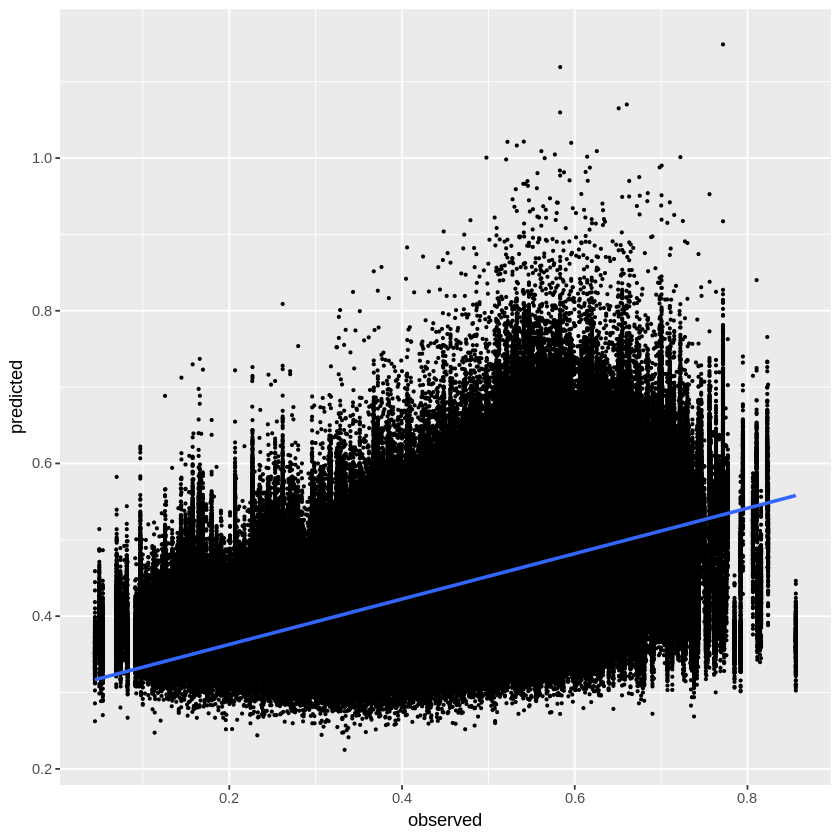

In [10]:
ggplot(res_lasso_gaussian_smooth_trimmed_pred_controls, aes(x = observed, y = predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

In [11]:
cor(res_lasso_gaussian_smooth_trimmed_pred_controls$observed, res_lasso_gaussian_smooth_trimmed_pred_controls$predicted)

# Standardize = TRUE: ATAC_val 0.6929081
# Standardize = FALSE: ATAC_val 

ATAC_observed,0.5452418


## Save the predictions made with CV on controls to file

In [12]:
res_lasso_gaussian_smooth_trimmed_pred_controls <- controls_predictions %>% mutate(ATAC_observed = res_lasso_gaussian_smooth_trimmed_pred_controls$observed, 
                                                                                   ATAC_predicted = res_lasso_gaussian_smooth_trimmed_pred_controls$predicted)

head(res_lasso_gaussian_smooth_trimmed_pred_controls)

sample,bin,ATAC_observed,ATAC_predicted
PGDX16568P,chr10_400,0.5866651,0.4413225
PGDX16568P,chr10_40,0.1996134,0.3511683
PGDX16568P,chr10_4,0.5968816,0.4372524
PGDX16568P,chr10_401,0.2905764,0.3499719
PGDX16568P,chr10_402,0.2319729,0.3701156
PGDX16568P,chr10_403,0.2262170,0.3696206


In [13]:
write.table(res_lasso_gaussian_smooth_trimmed_pred_controls, snakemake@output[["output_pred"]], append = F, sep=',', col.names=T, row.names=F)

## Fit the model on all controls

In [14]:
y <- ATAC_val %>% as.matrix()
X <- all_samples_gaussian_trimmed_controls %>% as.matrix()

fit       <- glmnet(X, y, alpha = 1, lambda = lambda_smooth_cv, standardize = TRUE)
# saving the model
saveRDS(fit, snakemake@output[["output_model"]])

#tmp       <- predict(fit, s=lambda_smooth_cv, testdata)

## Predict on normalized, smoothed and trimmed cases using the model (fitted on all controls) and add the predictions to the file

In [15]:
#filename = "../../../data/all_samples_normalized_gaussian_smooth_trimmed_CASES.csv"
filename = snakemake@input[["input_test_data_trim"]]

In [16]:
small_test <- read_csv(file = filename, col_names = T, comment = "#", skip = 0, n_max = 20)
head(small_test)

Parsed with column specification:
cols(
  .default = col_double(),
  sample = col_character(),
  bin = col_character()
)
See spec(...) for full column specifications.


sample,bin,X80,X81,X82,X83,X84,X85,X86,X87,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
PGDX10344P1,chr10_400,2.635648e-05,2.551240e-05,3.041764e-05,3.743369e-05,4.529382e-05,7.822038e-05,1.088130e-04,1.352074e-04,...,0.0002692328,0.0002645551,0.0002411552,0.0002046561,0.0001627598,1.337986e-04,0.0001030308,9.631365e-05,9.505189e-05,1.074471e-04
PGDX10344P1,chr10_40,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.063345e-06,1.461970e-05,3.128720e-05,5.500537e-05,...,0.0001944052,0.0001867330,0.0001802170,0.0001743696,0.0001920661,1.991633e-04,0.0002152961,2.191585e-04,2.233594e-04,2.137830e-04
PGDX10344P1,chr10_4,5.872179e-05,5.289260e-05,5.340677e-05,5.454810e-05,6.798495e-05,7.621979e-05,8.256314e-05,9.338255e-05,...,0.0002578428,0.0002614286,0.0002683933,0.0002580492,0.0002405518,2.035011e-04,0.0001702625,1.276962e-04,9.172705e-05,7.422905e-05
PGDX10344P1,chr10_401,8.180537e-05,8.398114e-05,8.175570e-05,8.748995e-05,9.207371e-05,9.639651e-05,1.133106e-04,1.224668e-04,...,0.0002087284,0.0001672440,0.0001206191,0.0000962458,0.0000869615,9.938756e-05,0.0001326077,1.601019e-04,1.795923e-04,1.772339e-04
PGDX10344P1,chr10_402,1.476717e-05,2.345811e-05,4.079304e-05,5.457810e-05,6.599014e-05,7.245930e-05,8.060398e-05,8.075730e-05,...,0.0004394529,0.0004394405,0.0004194749,0.0003816848,0.0003506651,3.193917e-04,0.0002856203,2.735742e-04,2.720397e-04,2.660698e-04
PGDX10344P1,chr10_403,6.067274e-05,8.155138e-05,9.276169e-05,9.578039e-05,1.061449e-04,1.155964e-04,1.242783e-04,1.345972e-04,...,0.0001596542,0.0001474896,0.0001478111,0.0001549740,0.0001742598,2.056872e-04,0.0002243287,2.385956e-04,2.456770e-04,2.395614e-04


In [17]:
f <- function(df1, pos) {
    df1[3:323] <- lapply(df1[3:323], as.numeric)
    
    df <- df1 %>% select(-c("sample", "bin")) %>% as.matrix()
    tmp       <- as.vector(predict(fit, s=lambda_smooth_cv, df))
    
    pred_tibble <- tibble(sample = df1$sample, bin = df1$bin)
    pred_tibble <- inner_join(pred_tibble, ATAC, by="bin")
    pred_tibble <- pred_tibble %>% mutate(ATAC_predicted = tmp)
    
    #message(pred_tibble)
    write.table(pred_tibble, snakemake@output[["output_pred"]], append = TRUE, sep=',', col.names=F, row.names=F)
}

df <- read_delim_chunked(file = filename, 
                 callback = DataFrameCallback$new(f), 
                 chunk_size = 10000, col_names = T,
                 delim = ",", 
                 progress = show_progress())

Parsed with column specification:
cols(
  .default = col_double(),
  sample = col_character(),
  bin = col_character()
)
See spec(...) for full column specifications.
